# Differential variability comparison plots

In [479]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, precision_recall_curve

In [480]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [481]:
# import sys
# sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
# import memento
# import memento.simulate as simulate

In [482]:
import matplotlib
matplotlib.rcParams['legend.handlelength'] = 0

In [483]:
data_path = '/data_volume/memento/simulation/dv/'

In [484]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [485]:
%autoreload 2


### Compare DV methods

In [486]:

dv_adata = sc.read(data_path + 'high_expr_anndata.h5ad')
result = dv_adata.var.copy()
result['de'] = dv_adata.var['is_de'].values
result['dv'] = dv_adata.var['is_dv'].values
memento_dv = pd.read_csv(data_path + 'memento.csv', index_col=0)
basics_dv = pd.read_csv(data_path +'dv_basics.csv')
print('basics num', basics_dv.shape)
basics_dv.index = dv_adata.var.iloc[basics_dv['GeneName']].index.tolist()

result = memento_dv.join(result, how='left').join(basics_dv, how='inner')
result['dv'] = result['dv'].astype(bool)

result['basics_es'] = basics_dv['ResDispDistance'] * (basics_dv['ResultDiffResDisp']=='stim+') - basics_dv['ResDispDistance'] * (basics_dv['ResultDiffResDisp']=='stim+')
result['basics'] = 1- basics_dv['ProbDiffResDisp']
result['basics'] =  result['basics']
result['memento'] = result['pval']

result = result.dropna()

basics num (7902, 8)


In [487]:
methods =['memento', 'basics']

In [504]:
n=7
thresholds = {
    'memento':np.linspace(1e-5, 0.05,n),
    'basics':np.linspace(1e-5, 0.01, n)}

tpr_dict = {}
fdr_dict = {}
fpr_dict = {}
for method in methods:
    tpr = []
    fpr = []
    fdr = []

    for thresh in thresholds[method]:

        tpr.append((result.query('dv')[method] < thresh).mean())
        fdr.append(    1-result.query('{} < {}'.format(method, thresh))['dv'].mean()     )
        fpr.append(    (result.query('~dv')[method] < thresh).mean()       )
    tpr_dict[method] = tpr
    fpr_dict[method] = fpr
    fdr_dict[method] = fdr

Text(0.5, 0, 'P-value cutoff (memento)\nPr(null) cutoff (BASiCS)')

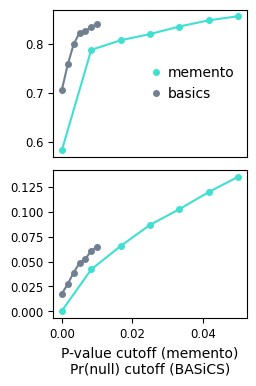

In [505]:
plt.figure(figsize=(2.5, 4))
plt.subplots_adjust(hspace=0.09)
plt.subplot(2, 1, 1)
for method in methods:
    plt.plot(thresholds[method], tpr_dict[method], '-o', label=method, ms=4)
plt.legend(methods, frameon=False, loc='center right')
plt.xticks([])

plt.subplot(2, 1, 2)
for method in methods:
    plt.plot(thresholds[method], fpr_dict[method], '-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.ylabel('FPR')
plt.xlabel('P-value cutoff (memento)\nPr(null) cutoff (BASiCS)')

In [512]:
topn_fdr = {}
topn_tpr = {}
num_n = 30
for method in methods:
    topn_fdr[method] = np.zeros(num_n)
    topn_tpr[method] = np.zeros(num_n)
    
    for idx, n in enumerate(np.linspace(50, 3000, num_n)):
        n = int(n)
        hits = result.sort_values(method).head(n)['dv'].values
        topn_fdr[method][idx] = (~hits).mean()
        topn_tpr[method][idx] = hits.sum() / result.dv.sum()
    

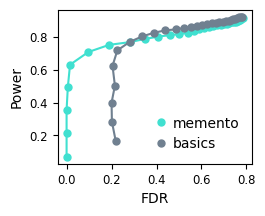

In [515]:
plt.figure(figsize=(2.5, 2))


for method in methods:
    plt.plot(topn_fdr[method], topn_tpr[method], '-o', label=method, ms=5)
plt.ylabel('Power'); plt.xlabel('FDR')
plt.legend(frameon=False, loc='lower right')
plt.savefig('fdr_tpr_dv.pdf', bbox_inches='tight')